# Face Mask Detection

Created by: Rauf Momin

Email: raufmomin26@gmail.com

#### Downloading and preparing the dataset

Link: https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Change the permissions
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

In [ ]:
!unzip /content/face-mask-12k-images-dataset.zip

#### Import Statements

In [4]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#### Data generator and pre-processing images

In [5]:
train_path = '/content/Face Mask Dataset/Train'
test_path = '/content/Face Mask Dataset/Test'
val_path = '/content/Face Mask Dataset/Validation'
labels = ['WithMask', 'WithoutMask']
n_classes = 2

In [6]:
image_size = (512, 512)
batch_size = 8

train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                                       horizontal_flip = True)

training_generator = train_data_generator.flow_from_directory(directory = train_path,
                                                              target_size = image_size,
                                                              color_mode = 'rgb',
                                                              class_mode = 'categorical',
                                                              batch_size = batch_size,
                                                              classes = labels, 
                                                              shuffle = True,
                                                              seed = 1)

val_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
validation_generator = val_data_generator.flow_from_directory(directory = val_path,
                                                              target_size = image_size,
                                                              color_mode = 'rgb',
                                                              class_mode = 'categorical',
                                                              batch_size = batch_size,
                                                              classes = labels,
                                                              shuffle = False,
                                                              seed = 1)

test_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
testing_generator = test_data_generator.flow_from_directory(directory = test_path,
                                                            target_size = image_size,
                                                            color_mode = 'rgb',
                                                            class_mode = 'categorical',
                                                            batch_size = batch_size,
                                                            classes = labels,
                                                            shuffle = False,
                                                            seed = 1)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(52, kernel_size=7, strides=1, input_shape=(512,512,3), padding='same'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(26, kernel_size=5, strides=1, padding='valid'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(12, kernel_size=2, strides=1, padding='valid'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(30),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 52)      7696      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 52)      0         
_________________________________________________________________
activation (Activation)      (None, 256, 256, 52)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 26)      33826     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 26)      0         
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 26)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 12)      1

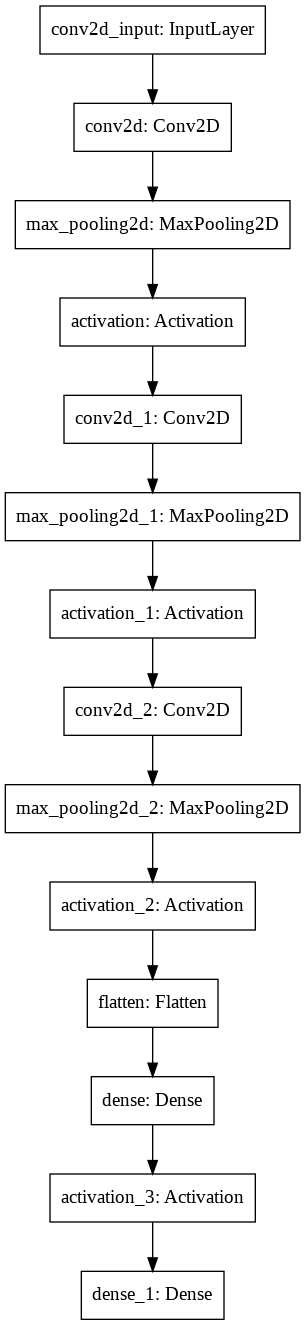

In [8]:
tf.keras.utils.plot_model(model)

In [9]:
model.compile(optimizer=tf.optimizers.Adam(lr = 1e-4, amsgrad = True), loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 6
steps_per_epoch = training_generator.n // training_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                 mode = 'min',
                                                 verbose = 1,
                                                 patience = 10)
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = '/content/model.h5',
                                                  monitor = 'val_loss',
                                                  verbose = 1,
                                                  save_best_only = True)
callbacks = [checkpointer, earlystopping]

history = model.fit(training_generator,
                    batch_size = batch_size,
                    epochs = epochs,
                    callbacks = callbacks,
                    validation_data = validation_generator,
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = validation_steps, 
                    validation_batch_size = batch_size)

Epoch 1/6
1250/1250 [==============================] - 137s 103ms/step - loss: 0.2682 - accuracy: 0.8785 - val_loss: 0.0594 - val_accuracy: 0.9850

Epoch 00001: val_loss improved from inf to 0.05942, saving model to /content/model.h5
Epoch 2/6
1250/1250 [==============================] - 131s 105ms/step - loss: 0.0857 - accuracy: 0.9710 - val_loss: 0.0566 - val_accuracy: 0.9825

Epoch 00002: val_loss improved from 0.05942 to 0.05655, saving model to /content/model.h5
Epoch 3/6
1250/1250 [==============================] - 131s 105ms/step - loss: 0.0678 - accuracy: 0.9771 - val_loss: 0.0345 - val_accuracy: 0.9900

Epoch 00003: val_loss improved from 0.05655 to 0.03451, saving model to /content/model.h5
Epoch 4/6
1250/1250 [==============================] - 132s 105ms/step - loss: 0.0541 - accuracy: 0.9802 - val_loss: 0.0377 - val_accuracy: 0.9900

Epoch 00004: val_loss did not improve from 0.03451
Epoch 5/6
1250/1250 [==============================] - 131s 105ms/step - loss: 0.0409 - acc

In [10]:
score = model.evaluate(training_generator, steps = training_generator.n // training_generator.batch_size)
print('Training Accuracy: {}'.format(score[1]))

score = model.evaluate(validation_generator, steps = validation_generator.n // validation_generator.batch_size)
print('Validation Accuracy: {}'.format(score[1]))

score = model.evaluate(testing_generator, steps = testing_generator.n // testing_generator.batch_size)
print('Testing Accuracy: {}'.format(score[1]))

1250/1250 [==============================] - 62s 50ms/step - loss: 0.0326 - accuracy: 0.9871
Training Accuracy: 0.9871000051498413
100/100 [==============================] - 4s 44ms/step - loss: 0.0298 - accuracy: 0.9900
Validation Accuracy: 0.9900000095367432
124/124 [==============================] - 6s 45ms/step - loss: 0.0502 - accuracy: 0.9798
Testing Accuracy: 0.9798387289047241


              precision    recall  f1-score   support

           0       0.99      0.97      0.98       483
           1       0.97      0.99      0.98       509

    accuracy                           0.98       992
   macro avg       0.98      0.98      0.98       992
weighted avg       0.98      0.98      0.98       992



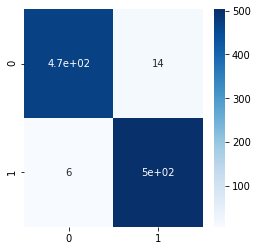

In [11]:
predicted_classes = np.argmax(model.predict(testing_generator, steps = testing_generator.n // testing_generator.batch_size +1), axis = 1)

true_classes = testing_generator.classes
class_labels = list(testing_generator.class_indices.keys())  

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (4, 4))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_classes, predicted_classes))

#### Face localization using MTCNN

In [12]:
!pip install --quiet mtcnn

     |████████████████████████████████| 2.3MB 19.1MB/s 


In [13]:
from mtcnn.mtcnn import MTCNN
import tensorflow as tf
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

model = tf.keras.models.load_model('/content/model.h5', compile = False)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

labels_2_text = {0: 'Mask', 1: 'No Mask'}

def detect_face_masks(image_name):
    image = tf.keras.preprocessing.image.load_img(image_name)
    image = tf.keras.preprocessing.image.img_to_array(image)
    
    detector = MTCNN()
    faces = detector.detect_faces(image)

    all_marked_faces = []

    for face in faces:
        image_sample = image
        bounding_box = face['box']
        x = bounding_box[0]
        y = bounding_box[1]
        w = bounding_box[2]
        h = bounding_box[3]
        roi = image_sample[y:y+h, x:x+w]
        roi = cv2.resize(roi, (512, 512))
        roi = np.expand_dims(roi, axis = 0)
        
        prob = model.predict(roi)
        pred = np.argmax(prob, axis = 1)
        
        blue_color = (0, 0, 255) 
        red_color = (255, 0, 0) 
        thickness = 2
        
        if labels_2_text[pred[0]] == 'Mask': 
            image_sample = cv2.rectangle(image_sample, (x, y), (x + w, y + h), blue_color, thickness)
        elif labels_2_text[pred[0]] == 'No Mask': 
            image_sample = cv2.rectangle(image_sample, (x, y), (x + w, y + h), red_color, thickness)

        color = (255, 255, 255) 
        fontScale = 0.8
        confidence = np.round(max(prob)*100, 2)
        cv2.putText(image_sample, labels_2_text[pred[0]], (x, y + 20), cv2.FONT_HERSHEY_SIMPLEX, fontScale, color, thickness)
        # cv2.putText(image_sample, str(confidence[0]), (x, y + 10), cv2.FONT_HERSHEY_PLAIN , fontScale, color, thickness=2)

    cv2_imshow(cv2.cvtColor(cv2.resize(image_sample, (400, 400)), cv2.COLOR_BGR2RGB))

In [15]:
image_names = ['/content/c.jpg', '/content/b.jpg']

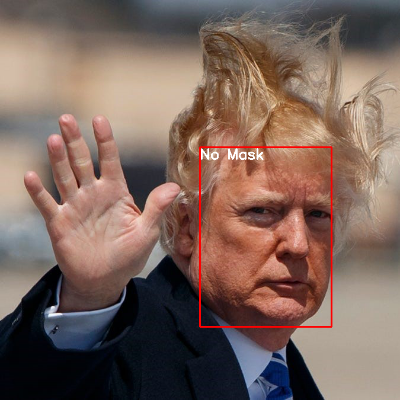

In [17]:
detect_face_masks(image_names[0])

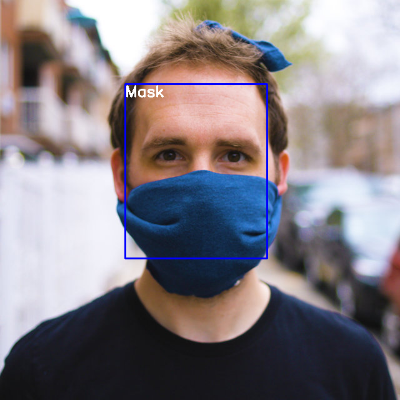

In [18]:
detect_face_masks(image_names[1])